# Spiking Neural Networks (SNNs): The Brain-Inspired AI
Spiking Neural Networks (SNNs) are the third generation of artificial neural networks that closely mimic how biological neurons communicate using precise electrical pulses (spikes) rather than continuous values. They are considered more biologically realistic than traditional ANNs and are used in neuromorphic computing for energy-efficient AI.

### **Key Features of SNNs vs. Traditional ANNs**

| Feature                | Traditional ANNs (MLPs, CNNs)       | Spiking Neural Networks (SNNs)       |
|------------------------|-------------------------------------|--------------------------------------|
| **Neuron Model**       | Continuous activations (sigmoid, ReLU) | **Spike-based** (discrete, event-driven) |
| **Information Encoding** | Rate coding (firing frequency)      | **Temporal coding** (exact spike timing) |
| **Learning Rule**      | Backpropagation (gradient-based)    | **STDP/Hebbian learning** (local, unsupervised) |
| **Energy Efficiency**  | High power consumption              | **Ultra-low power** (spikes are sparse) |
| **Hardware**           | GPUs/TPUs                          | **Neuromorphic chips** (Loihi, Akida) |
| **Training Difficulty**| Easy (gradient-based)              | Hard (non-differentiable spikes)     |
| **Biological Plausibility** | Low                              | **High** (mimics real neurons)       |

#### **Key Takeaways:**
- 🚀 **SNNs excel** in energy efficiency and temporal data processing.
- ⚡ **Best for** edge devices, neuromorphic hardware, and brain-like computing.
- ⚠️ **Challenges:** Training complexity and limited software support.

## Leaky Integrate-and-Fire (LIF) Neuron Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, threshold=1.0, rest_potential=0.0, reset_potential=0.0,
                 membrane_time=10.0, refractory_period=5.0):
        """
        Leaky Integrate-and-Fire Neuron
        
        Parameters:
        - threshold: Firing threshold (mV)
        - rest_potential: Resting membrane potential (mV)
        - reset_potential: Reset potential after spike (mV)
        - membrane_time: Membrane time constant (ms)
        - refractory_period: Refractory period after spike (ms)
        """
        self.threshold = threshold
        self.rest_potential = rest_potential
        self.reset_potential = reset_potential
        self.membrane_time = membrane_time
        self.refractory_period = refractory_period
        
        self.membrane_potential = rest_potential
        self.refractory_counter = 0
        self.spike_times = []
        
    def update(self, input_current, dt=1.0):
        """
        Update neuron state
        
        Returns:
        - spike: Boolean indicating if neuron fired
        """
        if self.refractory_counter > 0:
            self.refractory_counter -= dt
            self.membrane_potential = self.reset_potential
            return False
        
        # Membrane potential update
        dV = (self.rest_potential - self.membrane_potential + input_current) / self.membrane_time
        self.membrane_potential += dV * dt
        
        # Check for spike
        if self.membrane_potential >= self.threshold:
            self.membrane_potential = self.reset_potential
            self.refractory_counter = self.refractory_period
            self.spike_times.append(dt)
            return True
        return False

## Spiking Neural Network with STDP Learning

### Spike-Timing-Dependent Plasticity (STDP)
STDP is a biologically inspired unsupervised learning rule that modifies synaptic strength based on the precise timing of spikes between connected neurons. It is a form of Hebbian learning ("neurons that fire together, wire together") but with a temporal dependence.


Key Idea
- If a presynaptic neuron (input) fires before a postsynaptic neuron (output), the synapse is strengthened (Long-Term Potentiation, LTP).

- If the presynaptic neuron fires after, the synapse is weakened (Long-Term Depression, LTD).

This creates a causal relationship where synapses that consistently contribute to firing the postsynaptic neuron are reinforced.

In [2]:
class SNN:
    def __init__(self, n_inputs, n_neurons, n_outputs):
        """
        Spiking Neural Network with STDP learning
        
        Parameters:
        - n_inputs: Number of input neurons
        - n_neurons: Number of hidden layer neurons
        - n_outputs: Number of output neurons
        """
        # Input layer (just passes spikes)
        self.n_inputs = n_inputs
        
        # Hidden layer
        self.hidden_neurons = [LIFNeuron() for _ in range(n_neurons)]
        
        # Output layer
        self.output_neurons = [LIFNeuron() for _ in range(n_outputs)]
        
        # Initialize weights with random values
        self.weights_input_hidden = np.random.rand(n_inputs, n_neurons) * 0.5
        self.weights_hidden_output = np.random.rand(n_neurons, n_outputs) * 0.5
        
        # STDP parameters
        self.tau_plus = 20.0  # LTP time constant
        self.tau_minus = 20.0  # LTD time constant
        self.A_plus = 0.01     # LTP learning rate
        self.A_minus = 0.01    # LTD learning rate
        
        # Spike traces for STDP
        self.x = np.zeros(n_inputs)      # Presynaptic traces (input layer)
        self.y = np.zeros(n_neurons)     # Presynaptic traces (hidden layer)
        self.z = np.zeros(n_outputs)     # Postsynaptic traces (output layer)
        
    def forward(self, input_spikes, dt=1.0):
        """
        Process input spikes through the network
        
        Returns:
        - hidden_spikes: Spikes from hidden layer
        - output_spikes: Spikes from output layer
        """
        # Update spike traces (exponential decay)
        self.x *= np.exp(-dt/self.tau_plus)
        self.y *= np.exp(-dt/self.tau_plus)
        self.z *= np.exp(-dt/self.tau_minus)
        
        # Input layer spikes (just pass through)
        input_spike_indices = np.where(input_spikes)[0]
        self.x[input_spike_indices] += 1.0
        
        # Hidden layer computation
        hidden_input = np.dot(input_spikes, self.weights_input_hidden)
        hidden_spikes = np.zeros(len(self.hidden_neurons), dtype=bool)
        
        for i, neuron in enumerate(self.hidden_neurons):
            if neuron.update(hidden_input[i], dt):
                hidden_spikes[i] = True
                self.y[i] += 1.0
        
        # Output layer computation
        output_input = np.dot(hidden_spikes, self.weights_hidden_output)
        output_spikes = np.zeros(len(self.output_neurons), dtype=bool)
        
        for i, neuron in enumerate(self.output_neurons):
            if neuron.update(output_input[i], dt):
                output_spikes[i] = True
                self.z[i] += 1.0
        
        return hidden_spikes, output_spikes
    
    def update_weights_stdp(self, input_spikes, hidden_spikes, output_spikes, dt=1.0):
        """
        Update weights using STDP learning rule
        """
        # Input to Hidden weights update
        for i in np.where(input_spikes)[0]:
            for j in np.where(hidden_spikes)[0]:
                # LTP: input spike before hidden spike
                dw = self.A_plus * self.x[i] * np.exp(-(self.y[j] * dt)/self.tau_plus)
                self.weights_input_hidden[i,j] += dw
                
        for j in np.where(hidden_spikes)[0]:
            for i in np.where(input_spikes)[0]:
                # LTD: input spike after hidden spike
                if not hidden_spikes[j]:
                    dw = -self.A_minus * self.y[j] * np.exp(-(self.x[i] * dt)/self.tau_minus)
                    self.weights_input_hidden[i,j] += dw
        
        # Hidden to Output weights update (similar logic)
        for j in np.where(hidden_spikes)[0]:
            for k in np.where(output_spikes)[0]:
                # LTP: hidden spike before output spike
                dw = self.A_plus * self.y[j] * np.exp(-(self.z[k] * dt)/self.tau_plus)
                self.weights_hidden_output[j,k] += dw
                
        for k in np.where(output_spikes)[0]:
            for j in np.where(hidden_spikes)[0]:
                # LTD: hidden spike after output spike
                if not output_spikes[k]:
                    dw = -self.A_minus * self.z[k] * np.exp(-(self.y[j] * dt)/self.tau_minus)
                    self.weights_hidden_output[j,k] += dw
        
        # Clip weights to reasonable range
        self.weights_input_hidden = np.clip(self.weights_input_hidden, 0, 1)
        self.weights_hidden_output = np.clip(self.weights_hidden_output, 0, 1)

## Example: Pattern Recognition with SNN

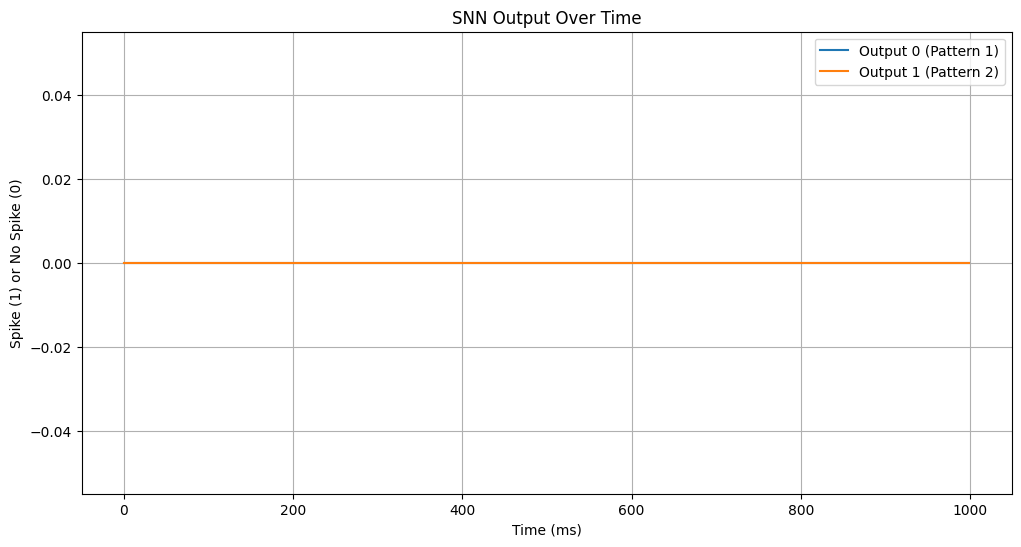

Final input-hidden weights:
[[0.44496063 0.05678201 0.08493923 0.14364334 0.20801897]
 [0.07134255 0.24438718 0.20155109 0.22163093 0.37037008]
 [0.23081862 0.29972343 0.09864248 0.44617417 0.16012295]
 [0.49202735 0.45473597 0.00746434 0.30348639 0.3321558 ]
 [0.15496804 0.14425362 0.25159781 0.46214499 0.44755383]
 [0.28178332 0.06384816 0.04560444 0.42492913 0.43567248]
 [0.44743637 0.13364993 0.18858178 0.07350114 0.11932834]
 [0.10536676 0.20191677 0.01937566 0.33442505 0.18863228]
 [0.06095819 0.38904983 0.38594249 0.33850385 0.3189421 ]
 [0.17617856 0.32289589 0.0032276  0.07750793 0.30044243]]

Final hidden-output weights:
[[0.0883836  0.32842592]
 [0.37181811 0.41822211]
 [0.02147713 0.11721073]
 [0.2969059  0.47275709]
 [0.1124404  0.02870498]]


In [3]:
# Create an SNN with 10 inputs, 5 hidden neurons, and 2 outputs
snn = SNN(n_inputs=10, n_neurons=5, n_outputs=2)

# Simulation parameters
timesteps = 1000
dt = 1.0  # ms

# Training patterns (two different input patterns)
pattern1 = np.array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0])  # Should activate output 0
pattern2 = np.array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1])  # Should activate output 1

# Store outputs for plotting
output0_history = []
output1_history = []

for t in range(timesteps):
    # Alternate between patterns every 100ms
    if (t // 100) % 2 == 0:
        input_spikes = (np.random.rand(10) < pattern1 * 0.2)  # 20% spike probability
    else:
        input_spikes = (np.random.rand(10) < pattern2 * 0.2)
    
    # Forward pass
    hidden_spikes, output_spikes = snn.forward(input_spikes, dt)
    
    # STDP learning
    snn.update_weights_stdp(input_spikes, hidden_spikes, output_spikes, dt)
    
    # Record outputs
    output0_history.append(output_spikes[0])
    output1_history.append(output_spikes[1])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(output0_history, label="Output 0 (Pattern 1)")
plt.plot(output1_history, label="Output 1 (Pattern 2)")
plt.title("SNN Output Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Spike (1) or No Spike (0)")
plt.legend()
plt.grid(True)
plt.show()

print("Final input-hidden weights:")
print(snn.weights_input_hidden)
print("\nFinal hidden-output weights:")
print(snn.weights_hidden_output)